# Introduction
Case of strong spatial variation in the snowline elevation within a Sentinel-2 tile.

Breaks LIS assumption of homogeneous snowline at the tile scale.

In [1]:
from scipy import ndimage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gdal 

In [2]:
# path to the FSC snow product 2020-Dec-26 tile 30TYN (Central Pyrenees)
f = '../data/FSC_20201226T105916_S2A_T30TYN_V200_1/FSC_20201226T105916_S2A_T30TYN_V200_1_FSCOG.tif'
fq = '../data/FSC_20201226T105916_S2A_T30TYN_V200_1/FSC_20201226T105916_S2A_T30TYN_V200_1_QCOG.tif'
fdem = '../data/COP-DEM_GLO-30-DGED_30TYN.tif'

In [3]:
# load product as numpy array
I = np.array(Image.open(f))
Q = np.array(Image.open(fq))

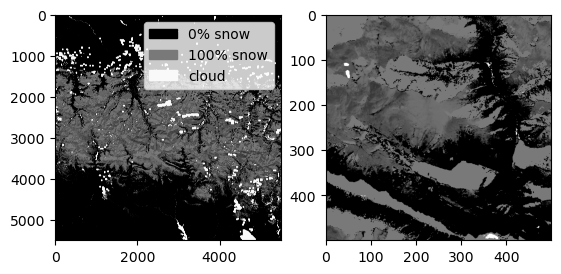

In [4]:
# plot the snow product
fig, (ax1, ax2) = plt.subplots(1, 2)
im = ax1.imshow(I,'gray')
labels = ['0% snow','100% snow','cloud']
values = [0,100,205]

# add legend (https://stackoverflow.com/a/40666123)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)) ]
im.axes.legend(handles=patches)

# zoom over a subset
ix1, ix2, iy1, iy2 = 3250, 3750, 2750, 3250
ax2.imshow(I[ix1:ix2,iy1:iy2],'gray');

In [5]:
# Binarize the FSC to snow/no-snow 
S = ((I>0) & (I<101)).astype(int)
# Binary image of cloud and low quality pixels
#C = ((Q>0)).astype(int)
C = ((I==205)).astype(int)

In [6]:
# Pixels marking the snow mask edges (inner boundary)
edgesSnowIn = S - ndimage.binary_erosion(S)
# Pixels marking the cloud mask edges (outer boundary)
edgesCloudOut = abs(C - ndimage.binary_dilation(C))
# The snowline pixels are the snow mask boundaries only if there is no adjacent cloud
snowline = (edgesSnowIn==1) & (edgesCloudOut==0)

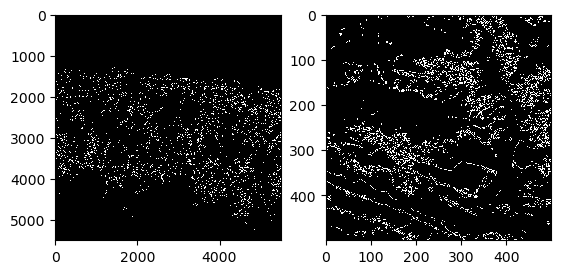

In [7]:
# plot snowline pixels
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(snowline,'gray',interpolation='none')
ax2.imshow(snowline[ix1:ix2,iy1:iy2],'gray',interpolation='none');

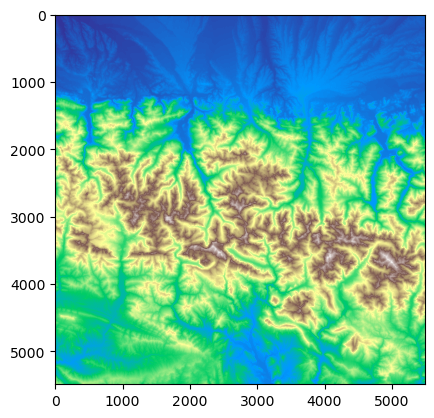

In [8]:
# load digital elevation model (already resampled to Sentinel-2 grid)
Z = np.array(Image.open(fdem))
plt.imshow(Z,'terrain');

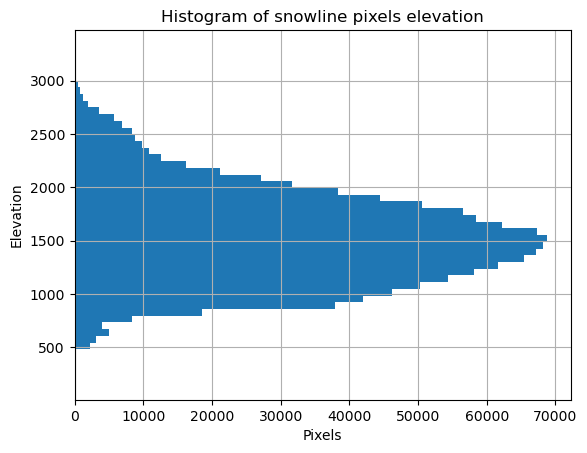

In [9]:
# extract elevation of snowline pixels
Zsnowline = Z[snowline]
# draw histogram 
plt.hist(Zsnowline, 50, orientation='horizontal')
plt.ylabel('Elevation')
plt.xlabel('Pixels')
plt.title('Histogram of snowline pixels elevation')
plt.grid(True)

In [10]:
# To relate the snowline to geographic position we need to read the metadata from the GeoTiff image
gtif = gdal.Open(f)
geoMatrix = gtif.GetGeoTransform()
# upper left corner x coordinate
ulx = geoMatrix[0]
# upper left corner y coordinate
uly = geoMatrix[3]
# pixel spacing in x 
xd = geoMatrix[1]
# pixel spacing in y
yd = geoMatrix[5]
# number of pixels in x
nx = gtif.RasterXSize
# number of pixels in y
ny = gtif.RasterYSize
# upper right corner x coordinate
urx = ulx + xd*nx
# lower left corner y coordinate
lly = uly + yd*ny

In [11]:
# create northing and easting arrays of pixel centers
x = np.linspace(ulx+xd/2, urx-xd/2, nx)
y = np.linspace(uly+yd/2, lly-yd/2, ny)
X, Y = np.meshgrid(x, y, indexing='xy')

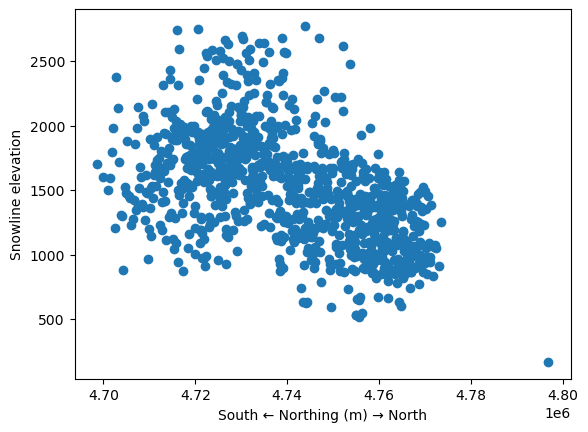

In [12]:
# extract northing of snowline pixels
Ysnowline = Y[snowline]
# plot snowline elevation vs. northing (subsample 1000 pixels)
plt.scatter(
    Ysnowline[np.linspace(0,len(Ysnowline),num=1000, dtype=int, endpoint=False)],
    Zsnowline[np.linspace(0,len(Ysnowline),num=1000, dtype=int, endpoint=False)])
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline elevation');

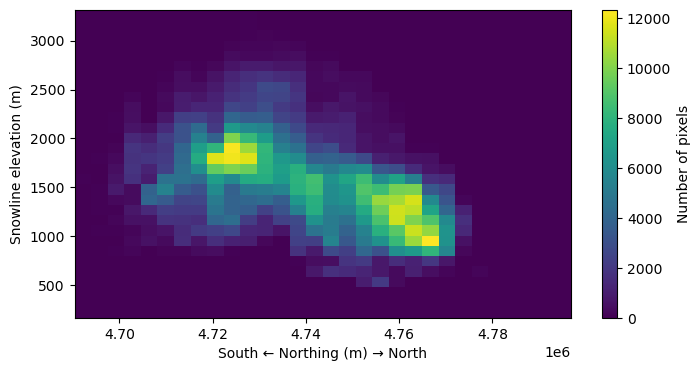

In [13]:
# same figure as a 2D histogram
plt.figure(figsize=[8,4])
plt.hist2d(Ysnowline, Zsnowline, bins=(30, 30))
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline elevation (m)')
plt.colorbar().set_label('Number of pixels')

In [25]:
# We want to evaluate the evolution of the snowline elevation along the north-south direction 
# first construct a snowline elevation array with NaN outside the snowline pixels
ZOnsnowline = np.where(snowline,Z,np.nan)
# take the average in the EW direction 
p10y = np.nanmean(ZOnsnowline,axis=1)
# We could also use the 10% percentile of the snowline elevation as the snowline low limit
# use nanpercentile (percentile function not implemented for masked arrays)
# p10y = np.nanpercentile(ZOnsnowline,10,axis=1)


/var/folders/n7/hfpz8l9j6dbg0x3j24zl70zh0000gp/T/ipykernel_23440/3835722457.py:5: RuntimeWarning: Mean of empty slice
  p10y = np.nanmean(ZOnsnowline,axis=1)


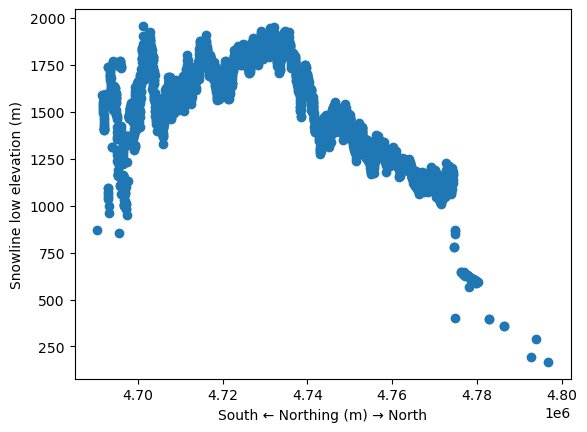

In [26]:
# plot snowline low elevation vs. northing
plt.scatter(y,p10y)
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline low elevation (m)');

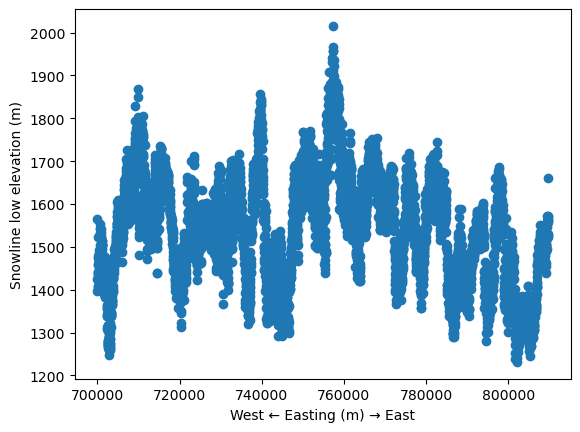

In [27]:
# same analysis along the east-west direction
p10x = np.nanmean(ZOnsnowline,axis=0)
#p10x = np.nanpercentile(ZOnsnowline,50,axis=0)
plt.scatter(x,p10x)
plt.xlabel('West ← Easting (m) → East')
plt.ylabel('Snowline low elevation (m)');

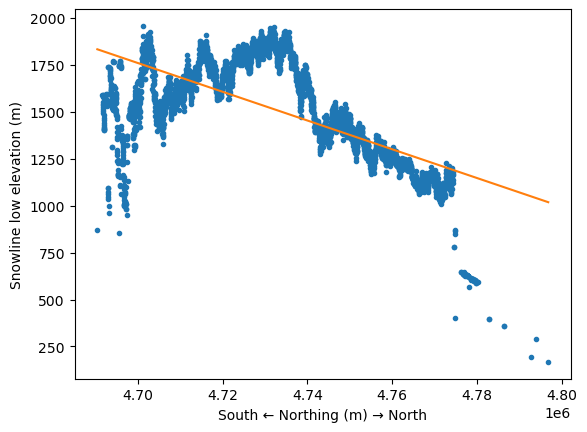

In [28]:
# Fit a polynomial function to model the variation of the snowline low elevation with northing
ix = np.logical_not(np.isnan(p10y))
fit = np.polyfit(y[ix], p10y[ix], 1)
pol = np.poly1d(fit)
plt.plot(y[ix], p10y[ix], '.', y[ix], pol(y[ix]), '-')
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline low elevation (m)');

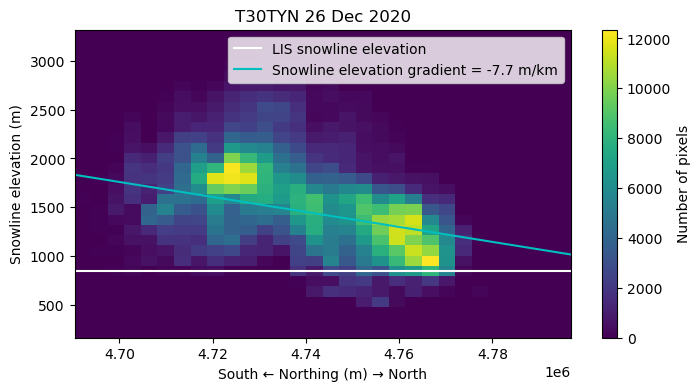

In [31]:
# same figure as a 2D histogram
plt.figure(figsize=[8,4])
plt.hist2d(Ysnowline, Zsnowline, bins=(30, 30))
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline elevation (m)')
plt.colorbar().set_label('Number of pixels')
plt.axhline(850, color='w', label='LIS snowline elevation')
plt.plot(y[ix], pol(y[ix]), 'c-', 
         label=f'Snowline elevation gradient = {1e3*pol.c[0]:.1f} m/km')
plt.legend()
plt.title('T30TYN 26 Dec 2020')
plt.savefig('zs_30TYN_20201226.png')